Here is the master pipeline

In [ ]:

import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
#%matplotlib notebook

# Finding image and object points

def undistort(test_img):
# prepare object points (our ideal reference), like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# Stores mtx and dist coefficients in a pickle file to use later
    nx=9    # Number of inner corners of our chessboard along x axis (or columns)
    ny=6    # Number of inner corners of our chessboard along y axis (or rows)

    objp = np.zeros((ny*nx,3), np.float32)                  #We have 9 corners on X axis and 6 corners on Y axis
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)       # Gives us coorinate points in pairs as a list of 54 items. It's shape will be (54,2)       

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space. These are the points for our ideal chessboard which we are using as a reference.       
    imgpoints = [] # 2d points in image plane. We'll extract these from the images given for caliberating the camera

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        calib_img = cv2.imread(fname)
        gray = cv2.cvtColor(calib_img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        # Grayscale conversion ensures an 8bit image as input.The next function needs that kind of input only. Generally color images are 24 bit images. (Refer "Bits in images" in notes) 
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)      # These will be same for caliberation image. The same points will get appended every time this fires up 
            imgpoints.append(corners)   # Corners 
            
            # Draw and display the corners                                  #This step can be completely skipped
            cv2.drawChessboardCorners(calib_img, (nx,ny), corners, ret)
            write_name = 'corners_found'+str(idx)+'.jpg'
            cv2.imwrite('output_files/corners_found_for_calib/'+write_name, calib_img)  
            cv2.imshow(write_name, calib_img)  #We dont want to see the images now so commenting out. TO see output later, un-comment these 3 lines
            cv2.waitKey(500)   #Delete after testing. These will be used to show you images one after the other

    cv2.destroyAllWindows()   #Delete this after testing
    
    # Test undistortion on an image

    test_img_size = (test_img.shape[1], test_img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img_size,None,None)
    
    # Use the above obtained results to undistort 
    undist_img = cv2.undistort(test_img, mtx, dist, None, mtx)
    
    cv2.imwrite('output_files/test_undist.jpg',undist_img)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "output_files/calib_pickle_files/dist_pickle.p", "wb" ) )
    #undist_img = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

    return undist_img
    
    

test_img= cv2.imread('camera_cal/calibration1.jpg')    #Note: Your image will be in BGR format
output=undistort(test_img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))        #Refer subplots in python libraries
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(output)
ax2.set_title('Undistorted Image', fontsize=30)
cv2.waitKey(500)
cv2.destroyAllWindows()


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(frame):
    
    def cal_undistort(img):
        # Reads mtx and dist matrices, peforms image distortion correction and returns the undistorted image

        import pickle

        # Read in the saved matrices
        my_dist_pickle = pickle.load( open( "output_files/calib_pickle_files/dist_pickle.p", "rb" ) )
        mtx = my_dist_pickle["mtx"]
        dist = my_dist_pickle["dist"]

        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        #undistorted_img =  cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)   #Use if you use cv2 to import image. ax.imshow() needs RGB image
        return undistorted_img

    
    def yellow_threshold(img, sxbinary):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        h_channel = hls[:,:,0]
        # Threshold color channel
        s_thresh_min = 100
        s_thresh_max = 255
        
        #for 360 degree, my value for yellow ranged between 35 and 50. So uska half kar diya
        h_thresh_min = 10    
        h_thresh_max = 25

        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

        # Combine the two binary thresholds
        yellow_binary = np.zeros_like(s_binary)
        yellow_binary[(((s_binary == 1) | (sxbinary == 1) ) & (h_binary ==1))] = 1
        return yellow_binary
    
    def xgrad_binary(img, thresh_min=30, thresh_max=100):
        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        # Threshold x gradient
        #thresh_min = 30    #Already given above
        #thresh_max = 100

        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return sxbinary
    
    def white_threshold(img, sxbinary, lower_white_thresh = 170):
        r_channel = img[:,:,0]
        g_channel = img[:,:,1]
        b_channel = img[:,:,2]
        # Threshold color channel
        r_thresh_min = lower_white_thresh
        r_thresh_max = 255
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
        
        g_thresh_min = lower_white_thresh
        g_thresh_max = 255
        g_binary = np.zeros_like(g_channel)
        g_binary[(g_channel >= g_thresh_min) & (g_channel <= g_thresh_max)] = 1

        b_thresh_min = lower_white_thresh
        b_thresh_max = 255
        b_binary = np.zeros_like(b_channel)
        b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

        white_binary = np.zeros_like(r_channel)
        white_binary[((r_binary ==1) & (g_binary ==1) & (b_binary ==1) & (sxbinary==1))] = 1
        return white_binary
        
    def thresh_img(img):
                       
       
        #sxbinary = xgrad_binary(img, thresh_min=30, thresh_max=100)
        sxbinary = xgrad_binary(img, thresh_min=25, thresh_max=130)
        yellow_binary = yellow_threshold(img, sxbinary)     #(((s) | (sx)) & (h))
        white_binary = white_threshold(img, sxbinary, lower_white_thresh = 150)
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[((yellow_binary == 1) | (white_binary == 1))] = 1
        
        out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
        
        return out_img
    
    def perspective_transform(img):
    
        # Define calibration box in source (original) and destination (desired or warped) coordinates

        img_size = (img.shape[1], img.shape[0])
        """Notice the format used for img_size. Yaha bhi ulta hai. x axis aur fir y axis chahiye. 
              Apne format mein rows(y axis) and columns (x axis) hain"""


        # Four source coordinates
        # Order of points: top left, top right, bottom right, bottom left
        
        src = np.array(
            [[435*img.shape[1]/960, 350*img.shape[0]/540],
             [530*img.shape[1]/960, 350*img.shape[0]/540],
             [885*img.shape[1]/960, img.shape[0]],
             [220*img.shape[1]/960, img.shape[0]]], dtype='f')
        

        # Next, we'll define a desired rectangle plane for the warped image.
        # We'll choose 4 points where we want source points to end up 
        # This time we'll choose our points by eyeballing a rectangle

        dst = np.array(
            [[290*img.shape[1]/960, 0],
             [740*img.shape[1]/960, 0],
             [740*img.shape[1]/960, img.shape[0]],
             [290*img.shape[1]/960, img.shape[0]]], dtype='f')


        #Compute the perspective transform, M, given source and destination points:
        M = cv2.getPerspectiveTransform(src, dst)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
              
        return warped, src, dst 

    def rev_perspective_transform(img, src, dst):

        img_size = (img.shape[1], img.shape[0])

        #Compute the perspective transform, M, given source and destination points:
        Minv = cv2.getPerspectiveTransform(dst, src)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        un_warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
              
        return un_warped, Minv 

    
    def draw_polygon(img1, img2, src, dst):
        src = src.astype(int)  #Very important step (Pixels cannot be in decimals)
        dst = dst.astype(int)
        cv2.polylines(img1, [src], True, (255,0,0), 3)
        cv2.polylines(img2, [dst], True, (255,0,0), 3)
    
    def histogram_bottom_peaks (warped_img):
        # This will detect the bottom point of our lane lines
        
        # Take a histogram of the bottom half of the image
        bottom_half = warped_img[((2*warped_img.shape[0])//5):,:,0]     # Collecting all pixels in the bottom half
        histogram = np.sum(bottom_half, axis=0)                         # Summing them along y axis (or along columns)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)        # 1D array hai histogram toh uska bas 0th index filled hoga 
        #print(np.shape(histogram))     #OUTPUT:(1280,)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        return leftx_base, rightx_base
    
    def find_lane_pixels(warped_img):
    
        leftx_base, rightx_base = histogram_bottom_peaks(warped_img)
   
        
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin. So width = 2*margin 
        margin = 90
        # Set minimum number of pixels found to recenter window
        minpix = 1000    #I've changed this from 50 as given in lectures
    
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped_img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_img.nonzero()  #pixel ke coordinates dega 2 seperate arrays mein
        nonzeroy = np.array(nonzero[0])    # Y coordinates milenge 1D array mein. They will we arranged in the order of pixels
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base         #initially set kar diya hai. For loop ke end mein change karenge
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []   # Ismein lane-pixels ke indices collect karenge. 
                              # 'nonzerox' array mein index daalke coordinate mil jaayega
        right_lane_inds = []  

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_img.shape[0] - (window+1)*window_height
            win_y_high = warped_img.shape[0] - window*window_height
            """### TO-DO: Find the four below boundaries of the window ###"""
            win_xleft_low = leftx_current - margin  
            win_xleft_high = leftx_current + margin  
            win_xright_low = rightx_current - margin  
            win_xright_high = rightx_current + margin 
            
            """
            # Create an output image to draw on and visualize the result
            out_img = np.copy(warped_img)
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
            """

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            #Iska poora explanation seperate page mein likha hai
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]


            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on the mean position of the pixels in your current window (re-centre)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        """return leftx, lefty, rightx, righty, out_img""" #agar rectangles bana rahe ho toh out_image rakhna
        return leftx, lefty, rightx, righty
    
        
    def fit_polynomial(warped_img, leftx, lefty, rightx, righty, fit_history, variance_history, rad_curv_history):
        """This will fit a parabola on each lane line, give back lane curve coordinates, radius of curvature """
        
        #Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)

        # We'll plot x as a function of y
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        
        
        """Primary coefficient detection: 1st level of curve fitting where frame naturally detects poins and fit's curve"""
        #Steps: find a,b,c for our parabola: x=a(y^2)+b(y)+c
        """
        1.a) If lane pixels found, fit a curve and get the coefficients for the left and right lane
        1.b) If #pixels insuffient and curve couldn't be fit, use the curve from the previous frame if you have that data
        (In case of lack of points in 1st frame, fit an arbitrary parabola with all coeff=1: Expected to improve later on)
        
        2) Using coefficient we'll fit a parabola. We'll improve it with following techiniques later on: 
        - Variance lane pixels from parabola (to account for distance of curve points for )
        - Shape and position of parabolas in the previous frame, 
        - Trends in radius of curvature, 
        - Frame mirroring (fine tuning one lane in the frame wrt to the other) 
        """
        
        try:
            a1_new= left_fit[0]
            b1_new= left_fit[1]
            c1_new= left_fit[2]
            
            a2_new= right_fit[0]
            b2_new= right_fit[1]
            c2_new= right_fit[2]
            
            #Calculate the x-coordinates of the parabola. Here x is the dependendent variable and y is independent
            left_fitx = a1_new*ploty**2 + b1_new*ploty + c1_new
            right_fitx = a2_new*ploty**2 + b2_new*ploty + c2_new
            
            status = True
                
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            
            if(len(lane.curve_fit)!=5):    #If you dont have any values in the history
                left_fitx = 1*ploty**2 + 1*ploty     #This is a senseless curve. If it was the 1st frame, we need to do something
                right_fitx = 1*ploty**2 + 1*ploty
            else:                                   #replicate lane from previous frame if you have history
                left_fitx = fit_history[0][4][0]*ploty**2 + fit_history[0][4][1]*ploty + fit_history[0][4][2]
                right_fitx = fit_history[1][4][0]*ploty**2 + fit_history[1][4][1]*ploty + fit_history[1][4][2]
            lane.count=-1 #Restart your search in next frame. At the end of this frame, 1 gets added. Hence we'll get net 0. 
            
            status = False
    
        """VARIANCE: Average distance of lane pixels from our curve which we have fit"""
        # Calculating variance for both lanes in the current frame    
        left_sum = 0 
        for index in range(len(leftx)):
            left_sum+= abs(leftx[index]-(a1_new*lefty[index]**2 + b1_new*lefty[index] + c1_new))
        left_variance_new=left_sum/len(leftx)
        
                
        right_sum=0
        for index in range(len(rightx)):
            right_sum+= abs(rightx[index]-(a2_new*righty[index]**2 + b2_new*righty[index] + c2_new))
        right_variance_new=right_sum/len(rightx)
                 
        
        #If you have history for variance and curve coefficients
        
        if((len(lane.curve_fit)==5)&(len(lane.variance)==5)):
            
            
            left_variance_old = sum([(0.2*((5-index)**3)*element) for index,element in enumerate(variance_history[0])])/sum([0.2*((5-index)**3) for index in range(0,5)])
            right_variance_old = sum([(0.2*((5-index)**3)*element) for index,element in enumerate(variance_history[1])])/sum([0.2*((5-index)**3) for index in range(0,5)])

            
            # Finding weighted average for the previous elements data within fit_history
            a1_old= sum([(0.2*(index+1)*element[0]) for index,element in enumerate(fit_history[0])])/sum([0.2*(index+1) for index in range(0,5)])        
            b1_old= sum([(0.2*(index+1)*element[1]) for index,element in enumerate(fit_history[0])])/sum([0.2*(index+1) for index in range(0,5)])       
            c1_old= sum([(0.2*(index+1)*element[2]) for index,element in enumerate(fit_history[0])])/sum([0.2*(index+1) for index in range(0,5)])
            a2_old= sum([(0.2*(index+1)*element[0]) for index,element in enumerate(fit_history[1])])/sum([0.2*(index+1) for index in range(0,5)])        
            b2_old= sum([(0.2*(index+1)*element[1]) for index,element in enumerate(fit_history[1])])/sum([0.2*(index+1) for index in range(0,5)])       
            c2_old= sum([(0.2*(index+1)*element[2]) for index,element in enumerate(fit_history[1])])/sum([0.2*(index+1) for index in range(0,5)])
            
            
            a1_new = (a1_new*((left_variance_old)**2) + a1_old*((left_variance_new)**2))/(((left_variance_old)**2) + ((left_variance_new)**2)) 
            b1_new = (b1_new*((left_variance_old)**2) + b1_old*((left_variance_new)**2))/(((left_variance_old)**2) + ((left_variance_new)**2))
            c1_new = (c1_new*((left_variance_old)**2) + c1_old*((left_variance_new)**2))/(((left_variance_old)**2) + ((left_variance_new))**2)
            a2_new = (a2_new*((right_variance_old)**2) + a2_old*((right_variance_new)**2))/(((right_variance_old)**2) + ((right_variance_new))**2) 
            b2_new = (b2_new*((right_variance_old)**2) + b2_old*((right_variance_new)**2))/(((right_variance_old)**2) + ((right_variance_new))**2)
            c2_new = (c2_new*((right_variance_old)**2) + c2_old*((right_variance_new)**2))/(((right_variance_old)**2) + ((right_variance_new))**2)

            
            ### Tracking the difference in curve fit coefficients over the frame  
            # from last to last frame -> last frame
            del_a1_old = lane.coeff_diff[0][0]
            del_b1_old = lane.coeff_diff[0][1]
            del_c1_old = lane.coeff_diff[0][2]
            del_a2_old = lane.coeff_diff[1][0]
            del_b2_old = lane.coeff_diff[1][1]
            del_c2_old = lane.coeff_diff[1][2]
            
            # from last frame -> current frame 
            del_a1 = abs(a1_new - fit_history[0][4][0])   
            del_b1 = abs(b1_new - fit_history[0][4][1])
            del_c1 = abs(c1_new - fit_history[0][4][2])
            del_a2 = abs(a2_new - fit_history[1][4][0])
            del_b2 = abs(b2_new - fit_history[1][4][1])
            del_c2 = abs(c2_new - fit_history[1][4][2])
            
            lane.coeff_diff = [[del_a1, del_b1, del_c1], [del_a2, del_b2, del_c2]]

            
            
            # bas ab delta coefficient for each coefficient nikalna hai aur vo formula likh dena har element ke liye
            a1_new = (a1_new*(del_a1_old) + a1_old*(del_a1))/((del_a1_old) + (del_a1))
            b1_new = (b1_new*(del_b1_old) + b1_old*(del_b1))/((del_b1_old) + (del_b1))
            c1_new = (c1_new*(del_c1_old) + c1_old*(del_c1))/((del_c1_old) + (del_c1))
            """
            #print("a2_new",a2_new)
            #print("b2_new",b2_new)
            #print("c2_new",c2_new)
            """
            a2_new = (a2_new*(del_a2_old) + a2_old*(del_a2))/((del_a2_old) + (del_a2))
            b2_new = (b2_new*(del_b2_old) + b2_old*(del_b2))/((del_b2_old) + (del_b2))
            c2_new = (c2_new*(del_c2_old) + c2_old*(del_c2))/((del_c2_old) + (del_c2))
            """          
            #print("")
            #print("a2_old",a2_old)
            #print("b2_old",b2_old)
            #print("c2_old",c2_old)
            #print("")
            #print("a2_new",a2_new)
            #print("b2_new",b2_new)
            #print("c2_new",c2_new)
            """
        
        y_eval = np.max(ploty)
        # Calculation of R_curve (radius of curvature)
        left_curverad = (((1 + (2*a1_new*y_eval + b1_new)**2)**1.5) / (2*a1_new))
        right_curverad = (((1 + (2*a2_new*y_eval + b2_new)**2)**1.5) / (2*a2_new))
        
        if(len(lane.rad_curv)==5):
            """How to check series is decreasing or increasing"""
     
            slope_avg=0
            for i in range(0,4):
                slope_avg += ((slope_avg*i) + (rad_curv_history[0][i+1] - rad_curv_history[0][i]))/(i+1)
            
            # If this is not the point of inflection, and still the radius of curvature changes sign, discard the curve  
            # Left
            if (((rad_curv_history[0][4]>0) & (left_curverad<0) & (slope_avg>=0)) | ((rad_curv_history[0][4]<0) & (left_curverad>0) & (slope_avg<=0))):
                a1_new = fit_history[0][4][0]
                b1_new = fit_history[0][4][1]
                c1_new = fit_history[0][4][2]

            # Right    
            if (((rad_curv_history[1][4]>0) & (right_curverad<0) & (slope_avg>=0)) | ((rad_curv_history[1][4]<0) & (right_curverad>0) & (slope_avg<=0))):
                a2_new = fit_history[1][4][0]
                b2_new = fit_history[1][4][1]
                c2_new = fit_history[1][4][2]
        
        
        """FRAME MIRRORING: Fine tuning one lane wrt to the other same as they'll have similar curvature"""
        #Steps: 
        """
        1) Weighted average of the coefficients related to curve shape (a,b) to make both parabola a bit similar
        2) Adjusting the 'c' coefficient using the lane centre of previous frame and lane width acc to current frame
        """
        
        # We'll use lane centre for the previous frame to fine tune c of the parabola. First frame won't have a history so 
        # Just for the 1st frame, we'll define it according to itself and use. Won't make any impact but will set a base for the next frames 
        if (lane.count==0):
            lane.lane_bottom_centre = (((a2_new*(warped_img.shape[0]-1)**2 + b2_new*(warped_img.shape[0]-1) + c2_new) + (a1_new*(warped_img.shape[0]-1)**2 + b1_new*(warped_img.shape[0]-1) + c1_new))/2) 
        
        # We'll find lane width according to the latest curve coefficients till now 
        lane.lane_width = (((lane.lane_width*lane.count)+(a2_new*(warped_img.shape[0]-1)**2 + b2_new*(warped_img.shape[0]-1) + c2_new) - (a1_new*(warped_img.shape[0]-1)**2 + b1_new*(warped_img.shape[0]-1) + c1_new))/(lane.count+1))
        
        a1 = 0.8*a1_new + 0.2*a2_new
        b1 = 0.8*b1_new + 0.2*b2_new
        a2 = 0.2*a1_new + 0.8*a2_new
        b2 = 0.2*b1_new + 0.8*b2_new
        
        #c1 = 0.8*c1_new + 0.2*c2_new
        #c2 = 0.2*c1_new + 0.8*c2_new
        
        #T Taking the lane centre fromt the previous frame and finding "c" such that both lanes are equidistant from it.
        c1_mirror = ((lane.lane_bottom_centre - (lane.lane_width/2))-(a1*(warped_img.shape[0]-1)**2 + b1*(warped_img.shape[0]-1)))
        c2_mirror = ((lane.lane_bottom_centre + (lane.lane_width/2))-(a2*(warped_img.shape[0]-1)**2 + b2*(warped_img.shape[0]-1)))
        
        c1= 0.7*c1_new + 0.3*c1_mirror
        c2 = 0.7*c2_new + 0.3*c2_mirror
        
        
        # Now we'll find the lane centre of this frame and overwrite the global variable s that the next frame can use this value
        lane.lane_bottom_centre = (((a2*(warped_img.shape[0]-1)**2 + b2*(warped_img.shape[0]-1) + c2) + (a1*(warped_img.shape[0]-1)**2 + b1*(warped_img.shape[0]-1) + c1))/2)
        
        #print("lane.lane_width",lane.lane_width)
        #print("lane.lane_bottom_centre",lane.lane_bottom_centre)
        
        
        left_curverad = (((1 + (2*a1*y_eval + b1)**2)**1.5) / (2*a1))
        right_curverad = (((1 + (2*a2*y_eval + b2)**2)**1.5) / (2*a2))
        
        left_fitx = a1*ploty**2 + b1*ploty + c1
        right_fitx = a2*ploty**2 + b2*ploty + c2
        
        
        """
        print("left_curverad",left_curverad)
        print("left_curverad",right_curverad)
        
        print("a2",a2)
        print("b2",b2)
        print("c2",c2)
        
        print("")
        """
        
        
        return [[a1,b1,c1], [a2,b2,c2]], left_fitx, right_fitx, status, [left_variance_new, right_variance_new], [left_curverad,right_curverad], ploty
        # out_img here has boxes drawn and the pixels are colored 
        
        #return [[a1_new,b1_new,c1_new], [a2_new,b2_new,c2_new]], left_fitx, right_fitx, status, [left_variance_new, right_variance_new], ploty 
        
      
    def color_pixels_and_curve(out_img, leftx, lefty, rightx, righty, left_fitx, right_fitx):
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Converting the coordinates of our line into integer values as index of the image can't take decimals
        left_fitx_int = left_fitx.astype(np.int32)
        right_fitx_int = right_fitx.astype(np.int32)
        ploty_int = ploty.astype(np.int32)
        
        # Coloring the curve as yellow
        out_img[ploty_int,left_fitx_int] = [255,255,0]
        out_img[ploty_int,right_fitx_int] = [255,255,0]
        
        # To thicken the curve
        out_img[ploty_int,left_fitx_int+1] = [255,255,0]
        out_img[ploty_int,right_fitx_int+1] = [255,255,0]
        out_img[ploty_int,left_fitx_int-1] = [255,255,0]
        out_img[ploty_int,right_fitx_int-1] = [255,255,0]
        out_img[ploty_int,left_fitx_int+2] = [255,255,0]
        out_img[ploty_int,right_fitx_int+2] = [255,255,0]
        out_img[ploty_int,left_fitx_int-2] = [255,255,0]
        out_img[ploty_int,right_fitx_int-2] = [255,255,0]
        
        
        
    def search_around_poly(warped_img, left_fit, right_fit):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty

    def modify_array(array, new_value):
        if len(array)!=5:
            for i in range(0,5):
                array.append(new_value)

        else:
            dump_var=array[0]
            array[0]=array[1]
            array[1]=array[2]
            array[2]=array[3]
            array[3]=array[4]
            array[4]=new_value
        return array
    
   

    undist_img = cal_undistort(frame)
    thresh_img = thresh_img(undist_img)    # Note: This is not a binary iamge. It has been stacked already within the function
    warped_img, src, dst = perspective_transform(thresh_img)

    #draw_polygon(frame, warped_img, src, dst)   #the first image is the original image that you import into the system
    
    #print("starting count",lane.count)
    
    # Making the curve coefficient and variance history ready for our new frame
    left_fit_previous = [i[0] for i in lane.curve_fit] 
    right_fit_previous = [i[1] for i in lane.curve_fit]
    fit_history=[left_fit_previous, right_fit_previous]
        
    left_variance_previous = [i[0] for i in lane.variance]
    right_variance_previous = [i[1] for i in lane.variance]
    variance_history=[left_variance_previous, right_variance_previous]
    
    left_rad_curv_prev = [i[0] for i in lane.rad_curv]
    right_rad_curv_prev = [i[1] for i in lane.rad_curv]
    rad_curv_history = [left_rad_curv_prev, right_rad_curv_prev]
    #print(rad_curv_history)
    
    if (lane.count == 0):
        leftx, lefty, rightx, righty = find_lane_pixels(warped_img)     # Find our lane pixels first
    elif (lane.count > 0):
        leftx, lefty, rightx, righty = search_around_poly(warped_img, left_fit_previous[4], right_fit_previous[4])
        
    curve_fit_new, left_fitx, right_fitx, status, variance_new, rad_curv_new,ploty = fit_polynomial(warped_img, leftx, lefty, rightx, righty, fit_history, variance_history,rad_curv_history)
    
    
    
    lane.rad_curv = modify_array(lane.rad_curv, rad_curv_new)
    lane.detected = status
    lane.curve_fit = modify_array(lane.curve_fit, curve_fit_new)
    lane.variance = modify_array(lane.variance, variance_new)
    #print(lane.variance)
                
    # Now we'll color the lane pixels and plot the identified curve over the image    
    #color_pixels_and_curve(warped_img, leftx, lefty, rightx, righty, left_fitx, right_fitx)
    
    unwarped_img, Minv = rev_perspective_transform(warped_img, src, dst)
    
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped_img).astype(np.uint8)
    
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (frame.shape[1], frame.shape[0])) 
    # Combine the result with the original image

    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    

    lane.count = lane.count+1  
    
    #return warped_img
    #return color_warp
    #return result
    #return unwarped_img
    #return undist_img
    #return thresh_img
    return warped_img
    """#color pixel funcction ko un-comment kardena"""
    

Class has been created below 


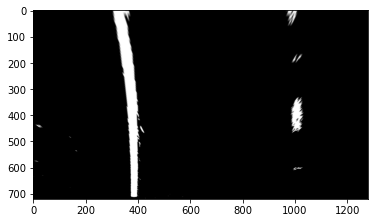

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.curve_fit = []  
        # Traking variance for the right lane
        self.variance = []
        #difference in fit coefficients between last and new fits. Just store the difference in coefficients for the last frame
        self.coeff_diff = [[0,0,0],[0,0,0]]        
        #Lane width measured at the start of reset
        self.lane_width = 0
        #Let's track the midpoint of the previous frame
        self.lane_bottom_centre = 0
        #radius of curvature of the line in some units
        self.rad_curv = []
        
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        
        
lane=Line()

import glob

test_images = glob.glob('test_images/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    
    #print ("success"+str(idx))
    
    write_name = 'output_files/img_results/boxed_warped_result '+str(idx+1)+'.jpg'
    
    color_corrected_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    lane.count = 0  # Necessary otherwise the images will start fixing the curve according to the history
    output = process_image(color_corrected_img)
    output_mod = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
    
    cv2.imwrite(write_name,output_mod)
    cv2.imshow(write_name, output_mod)
    cv2.waitKey(500)
    
cv2.destroyAllWindows()

    




frame1= mpimg.imread("test_images/test (4).jpg")

"""
frame2= mpimg.imread("my_test_images/Highway_snaps/image (2).jpg")
frame3= mpimg.imread("my_test_images/Highway_snaps/image (3).jpg")

frame4= mpimg.imread("my_test_images/Highway_snaps/image (4).jpg")
frame5= mpimg.imread("my_test_images/Highway_snaps/image (5).jpg")
frame6= mpimg.imread("my_test_images/Highway_snaps/image (6).jpg")
frame7= mpimg.imread("my_test_images/Highway_snaps/image (7).jpg")
frame8= mpimg.imread("my_test_images/Highway_snaps/image (8).jpg")
frame9= mpimg.imread("my_test_images/Highway_snaps/image (9).jpg")

%matplotlib notebook

(process_image(frame1))
(process_image(frame2))
(process_image(frame3))
(process_image(frame4))
(process_image(frame5))
(process_image(frame6))
(process_image(frame7))
(process_image(frame8))
"""
plt.imshow(process_image(frame1))



Video test

In [29]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.curve_fit = []  
        # Traking variance for the right lane
        self.variance = []
        #difference in fit coefficients between last and new fits. Just store the difference in coefficients for the last frame
        self.coeff_diff = [[0,0,0],[0,0,0]]       
        #Lane width measured at the start of reset
        self.lane_width = 0
        #Let's track the midpoint of the previous frame
        self.lane_bottom_centre = 0
        #radius of curvature of the line in some units
        self.rad_curv = []
        
        
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
lane=Line()

project_output = 'Project_Result.mp4'

clip1 = VideoFileClip("test_videos/project_video.mp4")

project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images! 
%time project_clip.write_videofile(project_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video Project_Result.mp4.
Moviepy - Writing video Project_Result.mp4



Moviepy - Done !
Moviepy - video ready Project_Result.mp4
Wall time: 36min 59s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

.